<a href="https://colab.research.google.com/github/jsansao/teic-20231/blob/main/TEIC_Licao11_TransferLearningKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lição 11 - Transfer Learning

Nesta tarefa, vamos comparar diferentes estruturas no reconhecimento de gestos de uma partida de pedra, papel e tesoura.

Utilizaremos redes pré-treinadas com a base imagenet e faremos o aprendizado por transferência. Neste tipo de treinamento, fixamos parte dos coeficientes da rede e adicionamos um novo classificador específico para a tarefa.

Vamos comparar as seguintes redes disponibilizadas pelo TensorFlow/Keras:



1. InceptionV3
2. VGG16
3. Xception
4. DenseNet

Para cada uma, você deverá determinar os melhores valores de acurácia (treinamento e validação), número de parâmetros treináveis e não treináveis (Ver o model.summary())







## Carregamento do banco de imagens

Os conjuntos estão divididos em dois arquivos zipados. O primeiro é o conjunto de treinamento, o segundo é o conjunto de validação.

Em cada arquivo zipado, temos três diretórios, correspondentes a imagens de pedra, papel e tesoura. Com o ImageGenerator, vamos gerar os tensores para serem processados.



In [2]:
!wget --no-check-certificate https://github.com/jsansao/rps/archive/refs/heads/main.zip

--2025-10-09 18:25:37--  https://github.com/jsansao/rps/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/jsansao/rps/zip/refs/heads/main [following]
--2025-10-09 18:25:37--  https://codeload.github.com/jsansao/rps/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.116.10
Connecting to codeload.github.com (codeload.github.com)|140.82.116.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ] 219.58M  34.5MB/s    in 6.3s    

2025-10-09 18:25:43 (34.8 MB/s) - ‘main.zip’ saved [230245117]



In [3]:
!unzip main.zip

Archive:  main.zip
2ab904a375abc266ab8ee31b5b8f06c256d01c2c
   creating: rps-main/
 extracting: rps-main/README.md      
   creating: rps-main/rps-test-set/
   creating: rps-main/rps-test-set/paper/
 extracting: rps-main/rps-test-set/paper/testpaper01-00.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-01.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-02.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-03.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-04.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-05.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-06.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-07.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-08.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-09.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-10.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-11.png  
 extracting: rps-main/rps-test-set/paper/testpaper01-12.p

## 1. InceptionV3

In [4]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3


pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = "imagenet")



for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


In [7]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator



train_dir = 'rps-main/rps/'
validation_dir = 'rps-main/rps-test-set/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150))

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [8]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 - 39s - 387ms/step - accuracy: 0.8255 - loss: 0.4618 - val_accuracy: 0.6150 - val_loss: 0.7041
Epoch 2/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 - 4s - 44ms/step - accuracy: 0.9288 - loss: 0.2293 - val_accuracy: 0.6250 - val_loss: 0.7303
Epoch 3/20
100/100 - 17s - 175ms/step - accuracy: 0.9435 - loss: 0.1738 - val_accuracy: 0.7750 - val_loss: 0.4464
Epoch 4/20
100/100 - 4s - 44ms/step - accuracy: 0.9500 - loss: 0.1450 - val_accuracy: 0.7800 - val_loss: 0.4183
Epoch 5/20
100/100 - 17s - 168ms/step - accuracy: 0.9655 - loss: 0.1094 - val_accuracy: 0.8650 - val_loss: 0.3092
Epoch 6/20
100/100 - 5s - 52ms/step - accuracy: 0.9692 - loss: 0.1428 - val_accuracy: 0.7950 - val_loss: 0.3329
Epoch 7/20
100/100 - 17s - 166ms/step - accuracy: 0.9660 - loss: 0.1069 - val_accuracy: 0.8000 - val_loss: 0.4094
Epoch 8/20
100/100 - 5s - 50ms/step - accuracy: 0.9635 - loss: 0.1301 - val_accuracy: 0.8050 - val_loss: 0.3506
Epoch 9/20
100/100 - 17s - 169ms/step - accuracy: 0.9675 - loss: 0.0921 - val_accuracy: 0.7800 - val_loss: 0.4581
Epoch 10/20
100/100 - 4s - 43ms/step - accuracy: 0.9692 - loss: 0.0735 - val_accuracy: 0.8000 - val_loss: 0

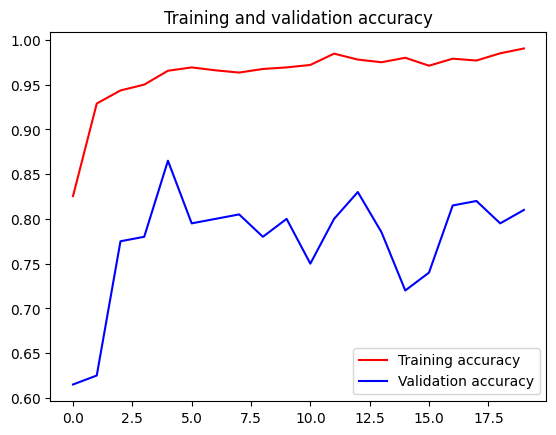

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## 2. VGG16

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np



pre_trained_model = VGG16(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

In [13]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [14]:
train_dir = 'rps-main/rps/'
validation_dir = 'rps-main/rps-test-set/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150))

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [15]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 - 25s - 248ms/step - accuracy: 0.6450 - loss: 0.9549 - val_accuracy: 0.8350 - val_loss: 0.7425
Epoch 2/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 - 5s - 46ms/step - accuracy: 0.8673 - loss: 0.7209 - val_accuracy: 0.8750 - val_loss: 0.6375
Epoch 3/20
100/100 - 19s - 189ms/step - accuracy: 0.9125 - loss: 0.5554 - val_accuracy: 0.9400 - val_loss: 0.4129
Epoch 4/20
100/100 - 5s - 45ms/step - accuracy: 0.9058 - loss: 0.4651 - val_accuracy: 0.9100 - val_loss: 0.3964
Epoch 5/20
100/100 - 18s - 177ms/step - accuracy: 0.9340 - loss: 0.3689 - val_accuracy: 0.9800 - val_loss: 0.2650
Epoch 6/20
100/100 - 5s - 48ms/step - accuracy: 0.9385 - loss: 0.3137 - val_accuracy: 0.9750 - val_loss: 0.2511
Epoch 7/20
100/100 - 17s - 171ms/step - accuracy: 0.9585 - loss: 0.2597 - val_accuracy: 0.9250 - val_loss: 0.2500
Epoch 8/20
100/100 - 5s - 53ms/step - accuracy: 0.9615 - loss: 0.2174 - val_accuracy: 0.9750 - val_loss: 0.2109
Epoch 9/20
100/100 - 17s - 173ms/step - accuracy: 0.9685 - loss: 0.2003 - val_accuracy: 0.9300 - val_loss: 0.2071
Epoch 10/20
100/100 - 5s - 52ms/step - accuracy: 0.9654 - loss: 0.1718 - val_accuracy: 0.9150 - val_loss: 0

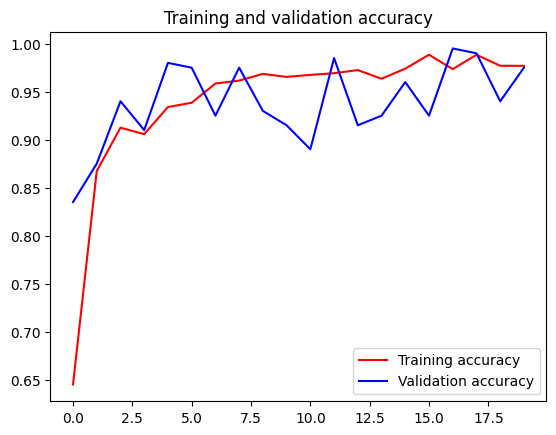

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## 3. Xception

In [17]:
import tensorflow.keras.applications.xception
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

pre_trained_model = Xception(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [20]:

train_dir = 'rps-main/rps/'
validation_dir = 'rps-main/rps-test-set/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150))

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [21]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 - 38s - 379ms/step - accuracy: 0.8420 - loss: 0.4422 - val_accuracy: 0.5750 - val_loss: 0.8572
Epoch 2/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 - 4s - 43ms/step - accuracy: 0.9115 - loss: 0.2309 - val_accuracy: 0.6650 - val_loss: 0.7814
Epoch 3/20
100/100 - 18s - 176ms/step - accuracy: 0.9415 - loss: 0.1868 - val_accuracy: 0.7800 - val_loss: 0.5158
Epoch 4/20
100/100 - 4s - 43ms/step - accuracy: 0.9654 - loss: 0.1268 - val_accuracy: 0.8000 - val_loss: 0.4708
Epoch 5/20
100/100 - 18s - 175ms/step - accuracy: 0.9615 - loss: 0.1290 - val_accuracy: 0.8300 - val_loss: 0.4446
Epoch 6/20
100/100 - 4s - 43ms/step - accuracy: 0.9500 - loss: 0.1231 - val_accuracy: 0.7700 - val_loss: 0.5766
Epoch 7/20
100/100 - 20s - 205ms/step - accuracy: 0.9705 - loss: 0.0964 - val_accuracy: 0.7250 - val_loss: 0.7439
Epoch 8/20
100/100 - 4s - 43ms/step - accuracy: 0.9904 - loss: 0.0654 - val_accuracy: 0.7250 - val_loss: 0.7034
Epoch 9/20
100/100 - 18s - 183ms/step - accuracy: 0.9715 - loss: 0.0867 - val_accuracy: 0.7350 - val_loss: 0.7174
Epoch 10/20
100/100 - 5s - 48ms/step - accuracy: 0.9673 - loss: 0.0985 - val_accuracy: 0.7950 - val_loss: 0

## 4. DenseNet

In [22]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
import numpy as np

pre_trained_model = DenseNet201(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_output = layer.output

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [24]:
train_dir = 'rps-main/rps/'
validation_dir = 'rps-main/rps-test-set/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150))

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [25]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 10,
            verbose = 2)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
100/100 - 84s - 836ms/step - accuracy: 0.8490 - loss: 0.4211 - val_accuracy: 0.8300 - val_loss: 0.3823
Epoch 2/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 - 5s - 54ms/step - accuracy: 0.9673 - loss: 0.1432 - val_accuracy: 0.8250 - val_loss: 0.4466
Epoch 3/20
100/100 - 18s - 184ms/step - accuracy: 0.9780 - loss: 0.0976 - val_accuracy: 0.8550 - val_loss: 0.3827
Epoch 4/20
100/100 - 5s - 55ms/step - accuracy: 0.9808 - loss: 0.0781 - val_accuracy: 0.8750 - val_loss: 0.3578
Epoch 5/20
100/100 - 18s - 178ms/step - accuracy: 0.9880 - loss: 0.0584 - val_accuracy: 0.9150 - val_loss: 0.3157
Epoch 6/20
100/100 - 5s - 54ms/step - accuracy: 0.9885 - loss: 0.0412 - val_accuracy: 0.8900 - val_loss: 0.3419
Epoch 7/20
100/100 - 18s - 177ms/step - accuracy: 0.9865 - loss: 0.0452 - val_accuracy: 0.8750 - val_loss: 0.3975
Epoch 8/20
100/100 - 10s - 101ms/step - accuracy: 0.9865 - loss: 0.0408 - val_accuracy: 0.8500 - val_loss: 0.5249
Epoch 9/20
100/100 - 18s - 185ms/step - accuracy: 0.9915 - loss: 0.0390 - val_accuracy: 0.9000 - val_loss: 0.2328
Epoch 10/20
100/100 - 5s - 48ms/step - accuracy: 0.9885 - loss: 0.0417 - val_accuracy: 0.8700 - val_loss: